In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

numerical = [
    #'Id', 
    'Year', 
    'Age',
    'Height', 'Weight', 'BMI', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle',
    'School',
]
categorical = [
    #'School', 
    'Player_Type', 'Position_Type', 
    #'Position'
]
dum_categorical = []
target = 'Drafted'

objectives = {
    'LGB': None,
    'RF': None,
    'CAT': None,
    'LR': None,
}

def preprocess(path_train, path_test, is_dummies=False):
    train = pd.read_csv(path_train)
    test = pd.read_csv(path_test)
    targets = train[target]
    df = pd.concat([train.drop(target, axis=1), test], axis=0)

    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    df['School'] = df['School'].map(df['School'].value_counts())


    dummies = pd.get_dummies(df[categorical], columns=categorical, drop_first=False)
    dum_categorical.extend(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    
    df[numerical] = df[numerical].fillna(df.groupby('Weight')[numerical].transform("mean"))
    df[numerical] = df[numerical].fillna(df.groupby('Height')[numerical].transform("mean"))
    df[categorical] = df[categorical].astype('category')
    df[['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle']] = np.log1p(df[['Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle']])
    ss = StandardScaler()
    df[numerical] = ss.fit_transform(df[numerical])

    df_train = pd.concat([df.iloc[:len(train)], targets], axis=1)
    df_test = df.iloc[len(train):]
    return df_train, df_test

df_train, df_test = preprocess("../data/train.csv", "../data/test.csv")
len(df_train)

2781

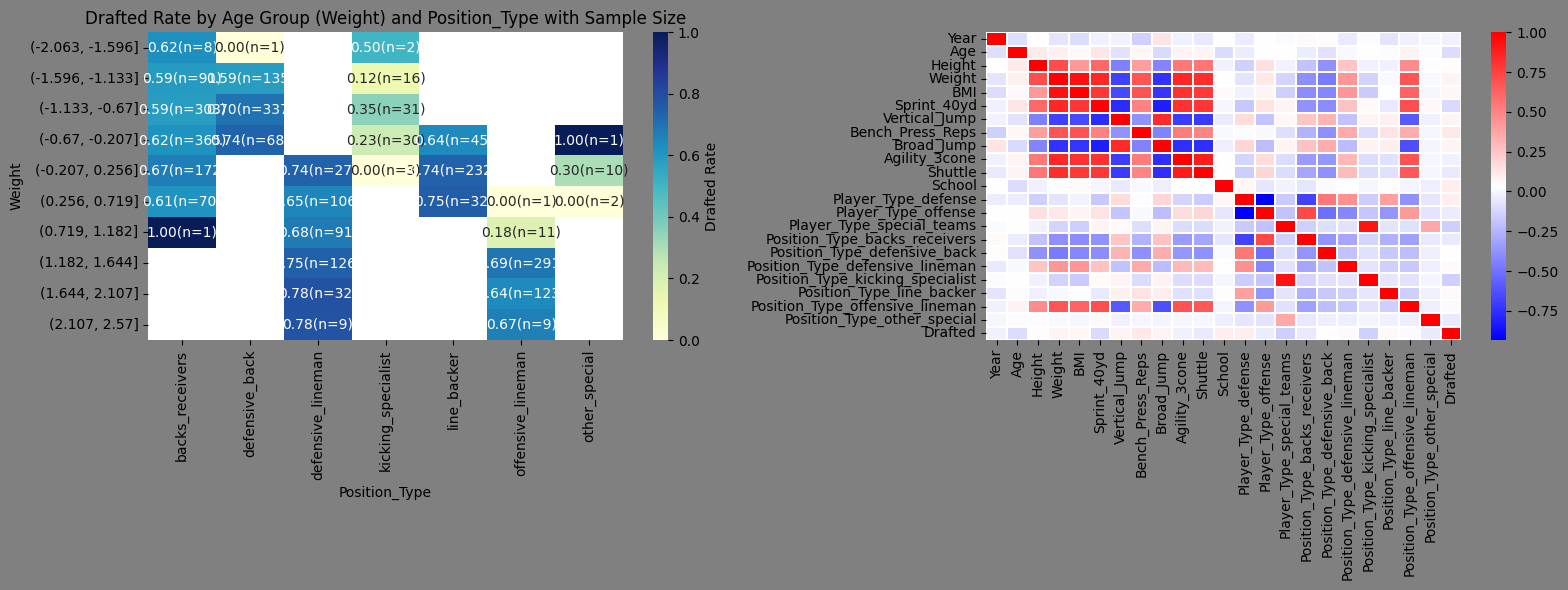

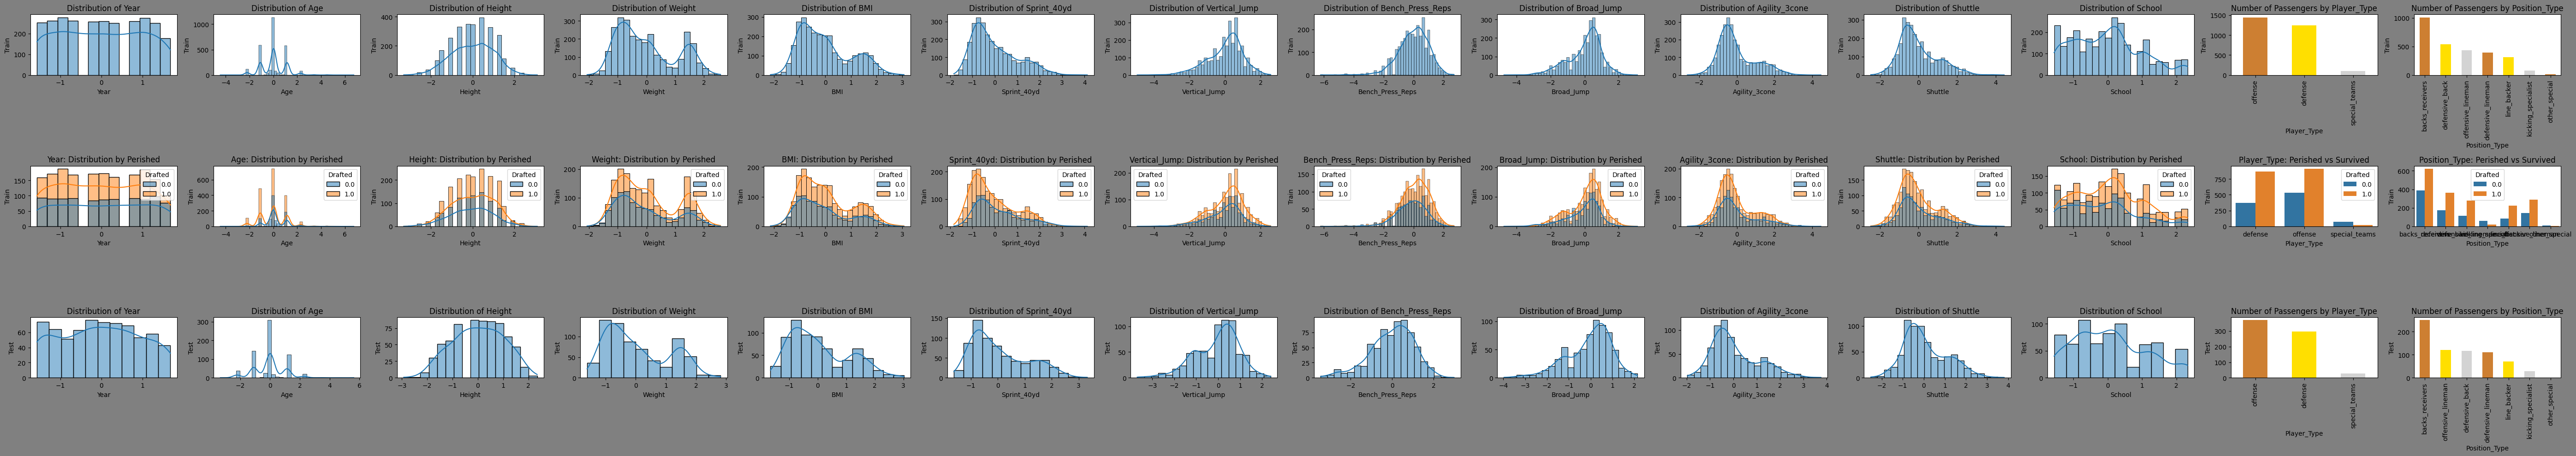

In [2]:
from target_rate import target_rate
target_rate(df_train, df_test, numerical_feature='Weight', boolean_feature='Position_Type', target=target, numerical=numerical, categorical=categorical, dum_categorical=dum_categorical, q=False, n=10, is_annot=False)

In [ ]:
from objective import Objective
from models import LGB, RF, CAT, LR
from params import lgb_params, rf_params, cat_params, lr_params
from sklearn.model_selection import train_test_split

X = df_train[numerical+categorical+dum_categorical]
y = df_train[target]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for key in objectives:
    print(key)
    if key=='LGB': objectives[key]=Objective(X, y, model=LGB, params=lgb_params, numerical=numerical, categorical=categorical, n_trial=30)
    if key=='RF': objectives[key]=Objective(X, y, model=RF, params=rf_params, numerical=numerical, categorical=dum_categorical, n_trial=10)
    if key=='CAT': objectives[key]=Objective(X, y, model=CAT, params=cat_params, numerical=numerical, categorical=categorical, n_trial=30)
    if key=='LR': objectives[key]=Objective(X, y, model=LR, params=lr_params, numerical=numerical, categorical=dum_categorical, n_trial=10)
    objectives[key]()

LGB


  0%|          | 0/30 [00:00<?, ?it/s]

RF


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# 最適なハイパーパラメータの表示
print("Best trial:")
for key in objectives:
    print(f'{key}: {objectives[key].study.best_trial.params}')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix

f, ax = plt.subplots(2, len(objectives), figsize=(6*len(objectives), 10), facecolor='gray', squeeze=False)
i = 0
for key in objectives:
    pred_prob = []
    feature_importances = []
    for model in objectives[key].best_model:
        pred_prob.append(model.predict(X_test))
        feature_importances.append(model.feature_importance())
    print(f"{key} Score:", roc_auc_score(objectives[key].best_y_valid, objectives[key].best_y_pred), ", Best Score:", objectives[key].best_score)
    feature_importance = pd.concat(feature_importances)
    feature_importance = feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
    tn, fp, fn, tp = confusion_matrix(objectives[key].best_y_valid, (objectives[key].best_y_pred > 0.5).astype(int)).ravel()
    
    df_conf = pd.DataFrame(
        [[tp, fp],
         [fn, tn]],
        index=[f"{target} (True)", f"not {target} (True)"],
        columns=[f"{target} (Pred)", f"not {target} (Pred)"]
    )
    
    sns.heatmap(df_conf, annot=True, fmt='d', cmap='Blues', ax=ax[0, i])
    ax[0, i].set_title(f"Confusion Matrix ({key})")
    
    sns.barplot(feature_importance, x='importance', y='feature', ax=ax[1, i])
    i += 1
plt.tight_layout()
plt.show()
    

In [ ]:
pred = np.mean([model.predict(df_test[numerical+categorical+dum_categorical]) for model in objectives[key].best_model for key in objectives], axis=0)
print(f'{target} rate: {np.count_nonzero(pred==1)/len(pred)}')
submission = pd.read_csv('../data/sample_submission.csv')
submission[target] = pred
submission

In [ ]:
submission.to_csv('../submission.csv',index=False)